In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [47]:
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToTensor, PILToTensor, Resize, Compose, ToImage,ToPILImage
from torchvision.models import resnet50, ResNet50_Weights


In [3]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()


transform = Compose([
    ToPILImage(mode="RGB"),
    transforms.v2.Lambda(lambda img: img.convert("RGB")),  # Ensure the image is in RGB mode

    #Resize(size=(224,224),antialias=True),
    ToTensor(),
    preprocess
])
print(preprocess)
dataset = datasets.Caltech101(root="./data",download=True,transform=transform)

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Files already downloaded and verified


/home/timo/anaconda3/envs/ml/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Training data: {len(train_dataset)}. Test data: {len(test_dataset)}")

Training data: 6941. Test data: 1736


In [5]:
batch_size = 64

train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size)

In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [7]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(401408, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 101)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CIFAR10Model().to(device)

In [8]:
model = resnet50(weights=weights)
model.fc = nn.Linear(2048,101)
model = model.to(device)

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.644998  [   64/ 6941]
loss: 1.392412  [ 6464/ 6941]
Test Error: 
 Accuracy: 86.4%, Avg loss: 1.227371 

Epoch 2
-------------------------------
loss: 0.704146  [   64/ 6941]
loss: 0.612323  [ 6464/ 6941]
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.684500 

Epoch 3
-------------------------------
loss: 0.303645  [   64/ 6941]
loss: 0.342197  [ 6464/ 6941]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.499657 

Epoch 4
-------------------------------
loss: 0.182399  [   64/ 6941]
loss: 0.219793  [ 6464/ 6941]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.411873 

Epoch 5
-------------------------------
loss: 0.126551  [   64/ 6941]
loss: 0.153259  [ 6464/ 6941]
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.361285 

Epoch 6
-------------------------------
loss: 0.094550  [   64/ 6941]
loss: 0.113241  [ 6464/ 6941]
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.328867 

Epoch 7
-------------------------------
loss: 0.074027  [   64/ 6941]
loss: 0.087723  [ 

In [14]:
def fastGradientSignMethod(input_image, target_label, model,epsilon):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    X = input_image.unsqueeze(0).to(device)
    #print(X)
    y = torch.tensor(target_label).unsqueeze(0).to(device)

    perturbation = torch.zeros(X.shape,requires_grad=True,device=device)
    adversarial_input = X+perturbation
    pred = model(adversarial_input)
    print(pred[0][target_label].item())
    loss = loss_fn(pred, y)
    loss.backward()
    with torch.no_grad():
        perturbation = epsilon * perturbation.grad.sign()
        adversarial_input = X + perturbation
    #print(perturbation)
    return adversarial_input.clamp_(0,1)

In [65]:
def show_image(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    unnormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    
    # Apply the unnormalize transform
    unnormalized_img = unnormalize(image)
    # Convert the tensor to a NumPy array for display
    unnormalized_img = unnormalized_img.permute(1, 2, 0).numpy()
    
    # Clip values to be in the range [0, 1]
    unnormalized_img = np.clip(unnormalized_img, 0, 1)
    
    # Display the image
    #plt.imshow(unnormalized_img)
    display(ToPILImage()(unnormalized_img))

In [90]:
# Read text labels from file
with open("labels.txt") as infile:
    labels = infile.readlines()
    labels = [x.strip() for x in labels]

In [91]:
def get_representative_images(dataset):
    # Returns one image per label
    images = [None] * 101
    
    for image,label in dataset:
        if images[label] == None:
            images[label] = image
            print(label)
    return images

'butterfly'

'scorpion'

# Adversarial Learning

In [105]:
print(labels[16])
print(labels[81])

butterfly
scorpion


In [95]:
import random

In [171]:
def getImage(dataset,target_label):
    if type(target_label) == str:
        target_label = labels.index(target_label)
        
    images = []
    for image,label in dataset:
        if label == target_label:
            images.append(image)
        
    return random.choice(images)

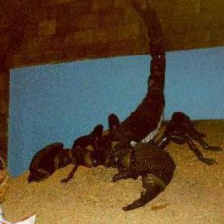

In [172]:
scorpion = getImage(dataset,"scorpion")
show_image(scorpion)

## Optimize input

In [178]:
def generate_adversarial_image(input_image,model,target):
    
    X = input_image.unsqueeze(0).to(device)
    y = torch.tensor(target).unsqueeze(0).to(device)
    X, y = X.to(device), y.to(device)
    perturbation = torch.zeros(X.shape,requires_grad=True,device=device)
    optimizer = torch.optim.Adam([perturbation], lr=1)
    
    loss_fn = nn.CrossEntropyLoss()
    epsilon = 0.1
    model.eval()
    for i in range(6):
        # Compute prediction error
        adversarial_input = X+perturbation
        adversarial_input = torch.clamp(adversarial_input, 0, 1)

        pred = model(adversarial_input)
        loss = loss_fn(pred, y)
        loss.backward()
        #print(f"Iteration {i}, Perturbation Norm: {perturbation.norm().item()}")
    
        optimizer.step()
        with torch.no_grad():
            perturbation.clamp_(-epsilon, epsilon)
        optimizer.zero_grad()
    image_tensor = (X+perturbation)[0].clamp_(0,1)
    return image_tensor.detach(),perturbation

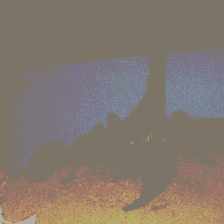

In [179]:
adversarial_image,perturbation = generate_adversarial_image(scorpion,model,16)
show_image(adversarial_image.cpu())

In [180]:
X = adversarial_image.unsqueeze(0).to(device)
pred = model(X)
print(f"Confidence adversarial image: {pred[0][target_label].item()}")

print(labels[pred.argmax(1)])

Confidence adversarial image: -10.910988807678223
butterfly


## Fast Gradient Sign Method

In [ ]:
def fastGradientSignMethod(input_image, target_label, model,epsilon):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    X = input_image.unsqueeze(0).to(device)
    #print(X)
    y = torch.tensor(target_label).unsqueeze(0).to(device)

    perturbation = torch.zeros(X.shape,requires_grad=True,device=device)
    adversarial_input = X+perturbation
    pred = model(adversarial_input)
    print(f"Confidence original image: {pred[0][target_label].item()}")
    loss = loss_fn(pred, y)
    loss.backward()
    with torch.no_grad():
        perturbation = epsilon * perturbation.grad.sign()
        adversarial_input = X + perturbation
    #print(perturbation)
    return adversarial_input.clamp_(0,1).cpu()

In [ ]:
adversarial_image = fastGradientSignMethod(scorpion,labels.index("scorpion"),model,0.001)
show_image(adversarial_image[0])
X = adversarial_image.to(device)
pred = model(X)
print(f"Confidence adversarial image: {pred[0][target_label].item()}")

print(labels[pred.argmax(1)])